In [127]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
import seaborn as sns
import numpy as np
import rdkit
from collections import defaultdict
from IPython.display import SVG, display
from rdkit import Geometry
import matplotlib.pyplot as plt
import networkx as nx
print(rdkit.__version__)

2023.09.3


## RDKIT Drawing Examples
 - arrows and strings: https://greglandrum.github.io/rdkit-blog/posts/2023-05-03-new-release-highlights.html
 - polyfill: https://rdkit.blogspot.com/2020/10/molecule-highlighting-and-r-group.html
 - api: https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html
 - drawing opts: https://greglandrum.github.io/rdkit-blog/posts/2023-05-26-drawing-options-explained.html
 - older drawing: https://rdkit.blogspot.com/2020/04/new-drawing-options-in-202003-release.html

## Common Substructures
- posters: https://www.compoundchem.com/category/organic-chemistry/
- heterocycle wiki: https://en.wikipedia.org/wiki/Heterocyclic_compound#/media/File:Heterocycle_compounds.jpg


defaultdict(<class 'list'>, {'Benzene': [16, 17, 18, 19, 20, 21], 'Pyridine': [8, 9, 10, 11, 12, 13], 'Nitrile': [18, 23, 24], 'Trifluoromethane': [25, 26, 27, 28], 'Ether': [12, 15, 16], 'Alkane': [0]})


[17:09:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[17:09:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[17:09:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[17:09:40] Explicit valence for atom # 4 O, 4, is greater than permitted
[17:09:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[17:09:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2
[17:09:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[17:09:40] Can't kekulize mol.  Unkekulized atoms: 0 1 5
[17:09:40] Can't kekulize mol.  Unkekulized atoms: 0 1 5
[17:09:40] SMILES Parse Error: syntax error while parsing: [#6][F,Cl,Br,I]
[17:09:40] SMILES Parse Error: Failed parsing SMILES '[#6][F,Cl,Br,I]' for input: '[#6][F,Cl,Br,I]'
[17:09:40] SMILES Parse Error: syntax error while parsing: [#6][N][H2]
[17:09:40] SMILES Parse Error: Failed parsing SMILES '[#6][N][H2]' for input: '[#6][N][H2]'
[17:09:40] SMILES Parse Error: syntax error while parsing: [#6][N][H1]([#6])[#6]
[17:09:40] SMILES Parse Error: Failed pa

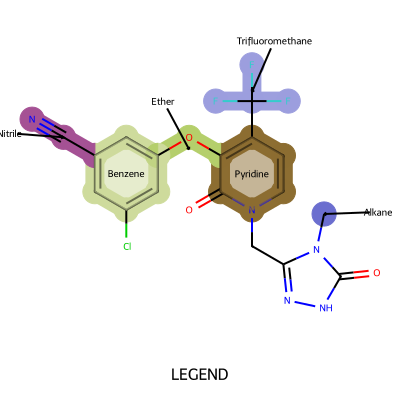

In [205]:
def labels_to_colors(x):
    ux = np.unique(x)
    # List of RGB triplets
    rgb_values = sns.color_palette("tab20b", len(ux))
    # Map label to RGB
    color_map = dict(zip(set(ux), rgb_values))
    colors = [color_map[e] for e in x]
    return colors

def hash_to_range(string_list, vals):
    hash_values = [hash(s) for s in string_list]
    range_size = len(vals)
    mapped_values = {s:vals[hash_val % range_size] for s,hash_val in zip(string_list,hash_values)}
    return mapped_values

def to_mol(obj):
    mol = None
    if isinstance(obj,Chem.Mol):
        return obj
    if isinstance(obj,str):
        mol = Chem.MolFromSmiles(obj)
    if mol is not None and isinstance(obj,str):
        mol = Chem.MolFromSmarts(obj)
    return mol

def smarts_to_aidx_bidx(mol,query_mol):

    #print(mol,query_mol)
    query_mol = to_mol(query_mol)
    mol = to_mol(mol)
    #print(mol,query_mol)

    if query_mol is not None:
        hit_ats = list(mol.GetSubstructMatch(query_mol))
        #print("Query Atoms:",hit_ats)
        hit_bonds = []
        for bond in query_mol.GetBonds():
            aid1 = hit_ats[bond.GetBeginAtomIdx()]
            aid2 = hit_ats[bond.GetEndAtomIdx()]
            hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())

        #print(hit_ats,hit_bonds)

        return hit_ats,hit_bonds
    else:
        return None

def mol_to_named_annotations(mol,highlightRadius = 0.5,k=1,h=400,w=400):

    named_smarts = {
        'Benzene':'c1ccccc1',
        'Pyridine':'n1ccccc1',
        'Nitrile':'C#N',
        'Trifluoromethane':'C(F)(F)F',
        'Ether':'[OD2]([#6])[#6]',
        'Ketone': 'cc(=O)c',

        # CAME FROM GPT - DO NOT TRUST
        'Pyridine': 'n1ccccc1',
        'Furan': 'o1cccc1',
        'Thiophene': 's1cccc1',
        'Pyrrole': 'n1cccc1',
        #'Imidazole': 'n1cnc[nH]1',
        'Piperidine': 'C1CCNCC1',
        'Morpholine': 'C1COCCN1',
        'Oxazole': 'o1cncc1',
        'Thiazole': 's1cncc1',
        'Indole': 'c1ccc2[nH]ccc2c1',
        'Quinoline': 'c1ccc2ncccc2c1',
        'Isoquinoline': 'c1ccc2c(c1)cccc2',
        'Pyrimidine': 'n1ccnc1',
        'Purine': 'n1cnc2c1ncn2',
        'Oxepane': 'C1CCOCC1',
        'Aziridine': 'C1CCN1',
        'Oxirane': 'C1CO1',
        'Thiane': 'C1CS1',
        'Dioxane': 'C1COCCO1',
        'Oxathiane': 'C1COS1',
        'Dithiane': 'C1CSCS1',
        'Dioxolane': 'C1OCOC1',
        'Morpholine oxide': 'C1CO[N+]([O-])C1',
        '1,3,4-Oxadiazole': 'o1nnnco1',
        '1,2,4-Triazole': 'c1nn[nH]n1',
        'Thiirane': 'C1CS1',
        '1,3,2-Dioxaborinane': 'B1COCO1',
        'Oxathiirane': 'C1COCS1',
        '1,2,4-Oxathiazolidine': 'C1CSSO1',
        'Oxadiazole': 'n1nc(no1)',
        'Pyrrolidine': 'C1CCNC1',
        'Diaziridine': 'C1CNN1',
        '1,4-Dioxane': 'C1OCCOCC1',
        '1,4-Dithiane': 'C1SCSCSC1',
        '1,2,3-Triazole': 'c1nn[nH]n1',
        '1,3-Dioxane': 'C1OCCOC1',
        '1,2,4-Oxadiazine': 'o1nnc[nH]o1',
        '1,2,3-Oxadiazole': 'o1nnc[oH]1',
        '1,2,3-Thiadiazole': 's1nnc[nH]s1',
        '1,2,4-Thiadiazole': 's1nnc[sH]1',
        '1,2,3-Triazol-4-one': 'c1nnoc1=O',
        '1,2,3-Triazol-4-ol': 'c1nnoc1',
        '1,2,3-Triazine': 'c1nnnc1',
        '1,2,4-Triazol-5-one': 'c1n[nH]c(=O)n1',
        '1,2,4-Triazol-5-ol': 'c1n[nH]c(=O)o1',
        '1,2,4-Triazol-3-one': 'c1n[nH]c(=O)c1',
        'Alkane': '[#6]',
        'Alkene': '[#6]=[#6]',
        'Alkyne': '[#6]#[#6]',
        'Alkyl halide': '[#6][F,Cl,Br,I]',
        'Alcohol': '[#6][OH]',
        'Ether': '[#6][O][#6]',
        'Aldehyde': '[#6][C]=O',
        'Ketone': '[#6][C](=O)[#6]',
        'Carboxylic acid': '[#6][C](=O)[O][H]',
        'Ester': '[#6][C](=O)[O][#6]',
        'Amide': '[#6][C](=O)[N][#6]',
        'Amine (primary)': '[#6][N][H2]',
        'Amine (secondary)': '[#6][N][H1]([#6])[#6]',
        'Amine (tertiary)': '[#6][N]([#6])[#6]',
        'Nitro group': '[#7](=[O])=[O]',
        'Nitrile': '[#6][C]#N',
        'Sulfide': '[#6][S][#6]',
        'Sulfoxide': '[#6][S](=O)[#6]',
        'Sulfone': '[#6][S](=O)(=O)[#6]',
        'Sulfonic acid': '[#6][S](=O)(=O)[O][H]',
        'Halide': '[F,Cl,Br,I]',
        'Aryl halide': '[#6][F,Cl,Br,I]',
        'Phenol': 'c[OH]',
        'Aromatic amine': 'c[NH2]',
        'Azide': '[N]=[N]=[N]',
        'Diazo group': '[#6]N=N',
        'Epoxide': '[#6]1[#8][#6]1',
        'Thiol': '[#6][SH]',
        'Isocyanate': 'N=C=O',
        'Nitrone': '[#6][N]=[O]',
        # Add more functional groups as needed
    }


    rgb_values = sns.color_palette("tab20b", 90)
    #rgb_values = sns.color_palette("hsv", 90)
    name_to_rgb = hash_to_range(named_smarts.keys(),rgb_values)
    #print("Named, Hashed To Colors:",name_to_rgb)

    bid_to_color = defaultdict(list)
    aid_to_color = defaultdict(list)
    
    name_to_aidx = defaultdict(list)
    for name,smarts in named_smarts.items():
        try:
            hit_ats,hit_bonds = smarts_to_aidx_bidx(mol,smarts)
            for aid in hit_ats:
                aid_to_color[aid].append((*name_to_rgb[name],0.99))
                name_to_aidx[name].append(aid)
            for bid in hit_bonds:
                bid_to_color[bid].append((*name_to_rgb[name],0.99))
        except IndexError:
            pass
        except TypeError:
            pass

    print(name_to_aidx)


    h = h
    w = w

    x = rdDepictor.Compute2DCoords(mol)
    rdDepictor.StraightenDepiction(mol)

    d2d = Chem.Draw.MolDraw2DSVG(w * 1, h * 1, w, h)
    dopts = d2d.drawOptions()

    dopts.addStereoAnnotation = True
    dopts.maxFontSize = -1
    dopts.baseFontSize = 0.4
    dopts.annotationFontScale = 0.15

    dopts.additionalAtomLabelPadding = 0.15
    dopts.highlightRadius = highlightRadius
    #dopts.highlightAtoms = hit_ats
    #dopts.highlightBonds = hit_bonds
    #dopts.setHighlightColour((0,.9,.9,.8))
    #dopts.setBackgroundColour((0,.9,.9,.3))
    #d2d.DrawMoleculeWithHighlights(mol,highlightAtoms = dict(aid_to_color),highlightBonds = dict(bid_to_color))

    d2d.DrawMoleculeWithHighlights(mol,'LEGEND',dict(aid_to_color),dict(bid_to_color),{},{})

    sssr = Chem.GetSSSR(mol)
    atom_coords = mol.GetConformer().GetPositions() # Get Coords
    ring_system_names = set()
    for rs in sssr:
        rs_aidx = set(rs)
        for name,aidx in name_to_aidx.items():
            name_aidx = set(aidx)
            X,Y = [],[]
            ps = []
            if rs_aidx.issubset(name_aidx):
                for aid in sorted(rs_aidx):
                    for atom_idx, coord in enumerate(atom_coords):
                        if aid == atom_idx:
                            x, y, _ = coord # print(f"Atom {atom_idx + 1}: ({x:.3f}, {y:.3f})")
                            pos = Geometry.Point2D(x,y)
                            ps.append(pos)
                            X.append(x)
                            Y.append(y)
                            ring_system_names.add(name)
            # Fill Poly
            if ps:
                d2d.SetFillPolys(True)
                d2d.SetColour((*name_to_rgb[name],0.5))
                d2d.DrawPolygon(ps)

    name_to_centorid = {}
    for name,aidx in name_to_aidx.items():
        X,Y = [],[]
        ps = []
        for aid in aidx:
            for atom_idx, coord in enumerate(atom_coords):
                if aid == atom_idx:
                    x, y, _ = coord # print(f"Atom {atom_idx + 1}: ({x:.3f}, {y:.3f})")
                    pos = Geometry.Point2D(x,y)
                    ps.append(pos)
                    X.append(x)
                    Y.append(y)

        # Get Centroid
        x_mean = np.mean(X)
        y_mean = np.mean(Y)
        i = Geometry.Point2D(x_mean,y_mean)
        name_to_centorid[name] = i

    # Figure out positions of arrow annotations
    G = nx.Graph()
    fix_pos = {}
    pos = {}
    for atom_idx, coord in enumerate(atom_coords):
        x, y, _ = coord
        G.add_node(atom_idx)
        pos[atom_idx] = (x,y)
    
    for name,i in name_to_centorid.items():
        if name not in ring_system_names:
            label_node = f"{name}_anchor"
            G.add_node(name)
            G.add_node(label_node)
            pos[label_node] = (i.x,i.y)
            G.add_edge(name,label_node)

    fixed_nodes = list(pos.keys())  # Get a list of fixed node names
    pos = nx.spring_layout(G, k=k, pos=pos, fixed=fixed_nodes)
    name_to_arrow_pos = dict()
    for node,pos_arr in pos.items():
        if node in name_to_centorid:
            x,y = pos_arr[0],pos_arr[1]
            name_to_arrow_pos[node] = Geometry.Point2D(x,y)
    
    # Annotate the structures
    for name,aidx in name_to_aidx.items():
        i = name_to_centorid[name]
        if name in ring_system_names:
            d2d.DrawString(name,i,0,rawCoords=False)
        else:
            #d2d.SetOffset(0,0)
            #d2d.SetLineWidth(40)
            arrow_label = name_to_arrow_pos[name]
            ni = Geometry.Point2D(float(i.x),float(i.y))
            arrow_end = Geometry.Point2D(float(name_to_arrow_pos[name].x),float(name_to_arrow_pos[name].y))
            offset_percent = 0.15
            x_delta = abs(arrow_end.x - i.x)*offset_percent
            y_delta = abs(arrow_end.y - i.y)*offset_percent

            
            if arrow_end.x > i.x:
                arrow_end.x += -x_delta
                ni.x += x_delta
            else:
                arrow_end.x += x_delta
                ni.x += -x_delta

            if arrow_end.y > i.y:
                arrow_end.y += -y_delta
                ni.y += y_delta
            else:
                arrow_end.y += y_delta
                ni.y += -y_delta

            # if the arrow is mostly vertical then center the label
            # if the arrow is mostly horizontal then left or right justify it
            justify = 0
            deg = np.degrees(np.arctan2(y_delta,x_delta))
            print(f"Degrees: {deg}")

            d2d.DrawArrow(arrow_end,i,rawCoords=False)
            d2d.DrawString(name,arrow_label,justify,rawCoords=False)

    # Wrap it up
    d2d.FinishDrawing()
    svg_str = d2d.GetDrawingText()
    return svg_str

mol = Chem.MolFromSmiles('Cn1c(n[nH]c1=O)Cn2ccc(c(c2=O)Oc3cc(cc(c3)Cl)C#N)C(F)(F)F')
svg_str = mol_to_named_annotations(mol)
display(SVG(svg_str))

defaultdict(<class 'list'>, {'Benzene': [16, 17, 18, 19, 20, 21], 'Pyridine': [8, 9, 10, 11, 12, 13], 'Nitrile': [18, 23, 24], 'Trifluoromethane': [25, 26, 27, 28], 'Ether': [12, 15, 16], 'Alkane': [0]})


[17:09:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[17:09:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[17:09:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[17:09:41] Explicit valence for atom # 4 O, 4, is greater than permitted
[17:09:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[17:09:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2
[17:09:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[17:09:41] Can't kekulize mol.  Unkekulized atoms: 0 1 5
[17:09:41] Can't kekulize mol.  Unkekulized atoms: 0 1 5
[17:09:41] SMILES Parse Error: syntax error while parsing: [#6][F,Cl,Br,I]
[17:09:41] SMILES Parse Error: Failed parsing SMILES '[#6][F,Cl,Br,I]' for input: '[#6][F,Cl,Br,I]'
[17:09:41] SMILES Parse Error: syntax error while parsing: [#6][N][H2]
[17:09:41] SMILES Parse Error: Failed parsing SMILES '[#6][N][H2]' for input: '[#6][N][H2]'
[17:09:41] SMILES Parse Error: syntax error while parsing: [#6][N][H1]([#6])[#6]
[17:09:41] SMILES Parse Error: Failed pa

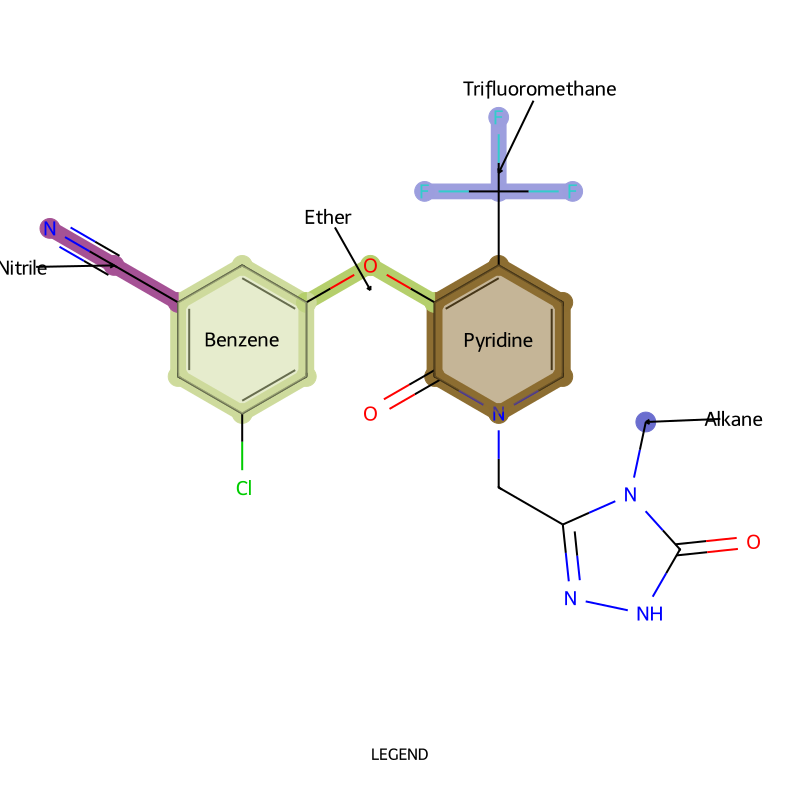

In [206]:
display(SVG(mol_to_named_annotations(mol,highlightRadius = 0.2,k=0.85,h=800,w=800)))

In [ ]:

mol = Chem.MolFromSmiles('Cn1c(n[nH]c1=O)Cn2ccc(c(c2=O)Oc3cc(cc(c3)Cl)C#N)C(F)(F)F')
p = rdDepictor.Compute2DCoords(mol)
print(p)
rdDepictor.StraightenDepiction(mol)
mol.GetAtomWithIdx(15).SetProp('atomNote','')
atom_coords = mol.GetConformer().GetPositions()

# Print atom coordinates
X = []
Y = []
G = nx.Graph()
fix_pos = {}
pos = {}
for atom_idx, coord in enumerate(atom_coords):
    x, y, _ = coord
    #print(f"Atom {atom_idx + 1}: ({x:.3f}, {y:.3f})")
    X.append(x)
    Y.append(y)
    G.add_node(atom_idx)
    pos[atom_idx] = (x,y)

    if atom_idx in [1,6,12]:
        label_node = f"Label - {atom_idx}"
        G.add_node(label_node)
        G.add_edge(atom_idx,label_node)

fixed_nodes = list(pos.keys())  # Get a list of fixed node names
pos = nx.spring_layout(G, k=2, pos=pos, fixed=fixed_nodes)
print(pos)
eX , eY = [],[]
for node,pos_arr in pos.items():
    if isinstance(node,str):
        x,y = pos_arr[0],pos_arr[1]
        eX.append(x)
        eY.append(y)
        


plt.scatter(X,Y)
plt.scatter(eX,eY,c='r')
mol

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
chembl2314369=Chem.MolFromSmiles('N#CC(C#N)=C1C(=O)c2cccc3cccc1c23')
rings = chembl2314369.GetRingInfo()

colors = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]

athighlights = defaultdict(list)
arads = {}
for i,rng in enumerate(rings.AtomRings()):
    for aid in rng:
        athighlights[aid].append(colors[i])
        arads[aid] = 0.3

bndhighlights = defaultdict(list)
for i,rng in enumerate(rings.BondRings()):
    for bid in rng:
        bndhighlights[bid].append(colors[i])
    
d2d = rdMolDraw2D.MolDraw2DSVG(400,400)
d2d.DrawMoleculeWithHighlights(chembl2314369,'CHEMBL2314369',dict(athighlights),dict(bndhighlights),arads,{})
d2d.FinishDrawing()
print(dict(athighlights))
SVG(d2d.GetDrawingText())


In [ ]:

# Example usage:
string_list = ["apple", "banana", "orange", "grape"]
range_size = 10  # Set the desired fixed int range size

result = hash_to_range(string_list, range_size)
print(result)